# Project

# NLP Model

## Імпорт бібліотек

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn import decomposition

from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans 

from sklearn.metrics.pairwise import cosine_similarity

## Ознайомлення з даними

In [2]:
#Завантаження даних
df_books = pd.read_csv("Book_Details.csv")

conn = sqlite3.connect("book_reviews.db")
df_reviews = pd.read_sql_query("SELECT * FROM book_reviews", conn)
conn.close()

print(df_books.info(), "\n")
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           16225 non-null  int64  
 1   book_id              16225 non-null  int64  
 2   cover_image_uri      16225 non-null  object 
 3   book_title           16225 non-null  object 
 4   book_details         16177 non-null  object 
 5   format               16225 non-null  object 
 6   publication_info     16225 non-null  object 
 7   authorlink           16225 non-null  object 
 8   author               16225 non-null  object 
 9   num_pages            16225 non-null  object 
 10  genres               16225 non-null  object 
 11  num_ratings          16225 non-null  int64  
 12  num_reviews          16225 non-null  int64  
 13  average_rating       16225 non-null  float64
 14  rating_distribution  16225 non-null  object 
dtypes: float64(1), int64(4), object(10)


In [3]:
# Ознайомлення з даними 
print(df_books.shape)
print(df_reviews.shape, "\n")
print(df_books.isnull().sum())
print(df_reviews.isnull().sum())

(16225, 15)
(63014, 9) 

Unnamed: 0              0
book_id                 0
cover_image_uri         0
book_title              0
book_details           48
format                  0
publication_info        0
authorlink              0
author                  0
num_pages               0
genres                  0
num_ratings             0
num_reviews             0
average_rating          0
rating_distribution     0
dtype: int64
book_id                      0
reviewer_id                  0
reviewer_name                0
likes_on_review           1979
review_content               0
reviewer_followers        4334
reviewer_total_reviews       0
review_date                  0
review_rating             1781
dtype: int64


## Data engineering

In [4]:
#Видалення зайвих ознак
df_books.drop(columns=["Unnamed: 0","cover_image_uri", "format", "publication_info", "authorlink", "num_ratings", "num_reviews", "rating_distribution", "num_pages"], inplace=True)
df_reviews.drop(columns=["reviewer_id", "reviewer_followers", "reviewer_total_reviews", "review_date", "review_rating"], inplace=True)

#Видалення відгуків без лайків
df_reviews.dropna(inplace=True)
df_reviews.drop(columns=["likes_on_review"], inplace=True)


In [5]:
df_reviews["book_id"] = df_reviews["book_id"].astype(int)
df_reviews = df_reviews.merge(df_books[['book_id', 'book_title']], on='book_id', how='left')
df_reviews.rename(columns={'book_title': 'book'}, inplace=True)

columns = ['book'] + [col for col in df_reviews.columns if col != 'book']
df_reviews = df_reviews[columns]



df_reviews

,book,book_id,reviewer_name,review_content
0,Daughter of the Deep,57094644,Sofia,Just when you thought he was done writing book...
1,Daughter of the Deep,57094644,megs_bookrack,Would you be shocked if I told you this was th...
2,Daughter of the Deep,57094644,Mariah,So you're telling me Anaisn'ta Daughter of Pos...
3,Daughter of the Deep,57094644,ale (semi hiatus) ‧ ₊˚୨ ♡ ୧ ₊˚,"*inserts vine ""anything for you, beyoncé""*upda..."
4,Seduce Me at Sunrise,2948832,chan ☆,i was excited about this one since it was so w...
...,...,...,...,...
61320,The Transhumanism Handbook,44242501,Stephen R.,This collection of essays from some of the mos...
61321,The Transhumanism Handbook,44242501,Michel Ch,Proved to me that transhumanism is somewhat ch...
61322,Teranesia,156787,Rob,"...All things considered,Teranesiais a novel c..."
61323,Teranesia,156787,Daniel Kenefick,"I don’t understand why Greg Egan generally, an..."


In [6]:
print(df_books.info(), "\n")
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   book_id         16225 non-null  int64  
 1   book_title      16225 non-null  object 
 2   book_details    16177 non-null  object 
 3   author          16225 non-null  object 
 4   genres          16225 non-null  object 
 5   average_rating  16225 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 760.7+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61325 entries, 0 to 61324
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   book            61325 non-null  object
 1   book_id         61325 non-null  int32 
 2   reviewer_name   61325 non-null  object
 3   review_content  61325 non-null  object
dtypes: int32(1), object(3)
memory usage: 1.6+ MB
None


### Знаходження кількості кластерів для кластеризації оцінки reviews

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kasay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Обробка reviews

In [8]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Функція для очищення тексту від стоп-слів та знаків пунктуації та застосування стеммера
def preprocess_text(text):
    tokens = word_tokenize(text) # Токенізація, щоб працювати зі словами 
    tokens = [ps.stem(word) for word in tokens if word not in stop_words and word not in string.punctuation] # Видалення стоп-слів та пунктуації та стемінг
    return ' '.join(tokens) #об'єднати результати в рядок

df_reviews_cl = df_reviews.copy()
df_reviews_cl["cleaned_review"] = df_reviews_cl["review_content"].apply(preprocess_text)

# Видалення повторів після обробки тексту
duplicates = df_reviews_cl.duplicated(subset=["cleaned_review"], keep='first')
duplicate_indices = df_reviews_cl[duplicates].index
df_reviews_cl.drop(columns=['review_content'], inplace=True)
df_reviews_cl.drop(index=duplicate_indices, inplace=True)
df_reviews.drop(index=duplicate_indices, inplace=True)
df_reviews_cl

,book,book_id,reviewer_name,cleaned_review
0,Daughter of the Deep,57094644,Sofia,just thought done write book rick strike
1,Daughter of the Deep,57094644,megs_bookrack,would shock i told first book i ever read fabu...
2,Daughter of the Deep,57094644,Mariah,so 're tell anaisn'ta daughter poseidon seem fake
3,Daughter of the Deep,57094644,ale (semi hiatus) ‧ ₊˚୨ ♡ ୧ ₊˚,insert vine `` anyth beyoncé '' updatewait the...
4,Seduce Me at Sunrise,2948832,chan ☆,excit one sinc well set first book unfortun po...
...,...,...,...,...
61320,The Transhumanism Handbook,44242501,Stephen R.,thi collect essay well-respect scholar researc...
61321,The Transhumanism Handbook,44242501,Michel Ch,prove transhuman somewhat childish lot theori ...
61322,Teranesia,156787,Rob,... all thing consid teranesiai novel compos n...
61323,Teranesia,156787,Daniel Kenefick,i ’ understand greg egan gener book specif get...


In [9]:
df_frating = pd.DataFrame(df_reviews_cl["cleaned_review"])
df_frating

,cleaned_review
0,just thought done write book rick strike
1,would shock i told first book i ever read fabu...
2,so 're tell anaisn'ta daughter poseidon seem fake
3,insert vine `` anyth beyoncé '' updatewait the...
4,excit one sinc well set first book unfortun po...
...,...
61320,thi collect essay well-respect scholar researc...
61321,prove transhuman somewhat childish lot theori ...
61322,... all thing consid teranesiai novel compos n...
61323,i ’ understand greg egan gener book specif get...


### Векторизація

In [10]:
# TF-IDF векторизація
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectors = tfidf_vectorizer.fit_transform(df_frating['cleaned_review'])

# Створення датафрейму з TF-IDF векторами
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # Датафрейм ще знадобиться для навчання nlp моделі

tfidf_df

,00,000,01,02,03,04,05,07,08,09,...,zero,zeu,zip,zodiac,zoe,zoey,zombi,zone,zoo,zweig
0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59573,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59574,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59575,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59576,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Декомпозиція 

In [11]:
pca = decomposition.PCA(n_components=2)
X = tfidf_df

batch_size = 1000

pca_batches = []    #декомпозиція частинами, щоб було достатньо пам'яті
for i in range(0, X.shape[0], batch_size):
    X_batch = X[i:i + batch_size]
    pca_batch = pca.fit_transform(X_batch)
    pca_batches.append(pca_batch)

X_1 = np.vstack(pca_batches)
print(X_1)


[[-0.15148068  0.09818827]
 [-0.0308218   0.00386611]
 [-0.1539762   0.00544415]
 ...
 [-0.06886799 -0.01438946]
 [ 0.00322478  0.0416589 ]
 [-0.08179457 -0.00365409]]


### Підбір кількості кластерів

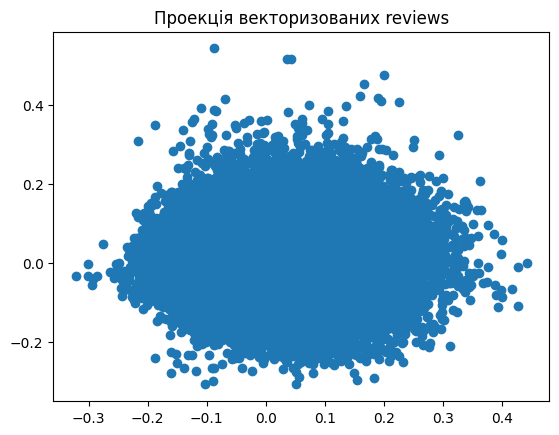

In [12]:
plt.scatter(X_1[:,0], X_1[:,1])
plt.title('Проекція векторизованих reviews')
plt.show()
#по графіку виділити певні кластери важко, але видні викиди

In [13]:
cluster_metrics = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, max_iter=100, n_init=10, random_state=42)
    kmeans.fit(X)
    cluster_metrics.append(kmeans.inertia_)

plt.plot(range(1, 6), cluster_metrics, marker='o')
plt.title('графік зміни інерції в залежності від кількості кластерів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Інерції')
plt.show()

In [14]:
# Більший кут в графіку випадає на 2-3 кластери, для зручності виберемо 2(хороший відгук і поганий)

### Обробка викидів

In [15]:
len(X_1)

59578

In [16]:
df_reviews.shape

(59578, 4)

In [17]:
# Використання Isolation Forest для знаходження викидів
iso_forest = IsolationForest(contamination=0.05)  # 5% даних будуть викидами
outliers = iso_forest.fit_predict(X_1)

# Індекси викидів 
outlier_indices = np.where(outliers == -1)[0]

# Видалення викидів з первинного датафрейму та з декомпозиторних даних(для візуалізації)
tfidf_df.drop(index=tfidf_df.index[outlier_indices], inplace=True)
X_1 = np.delete(X_1, outlier_indices, axis=0)
df_reviews.drop(index=df_reviews.index[outlier_indices], inplace=True)

# Перевірка результатів
print("Кількість відгуків після видалення викидів:", len(tfidf_df))
print("Кількість відгуків після видалення викидів:", len(X_1))

Кількість відгуків після видалення викидів: 56599
Кількість відгуків після видалення викидів: 56599


In [18]:
df_reviews.shape

(56599, 4)

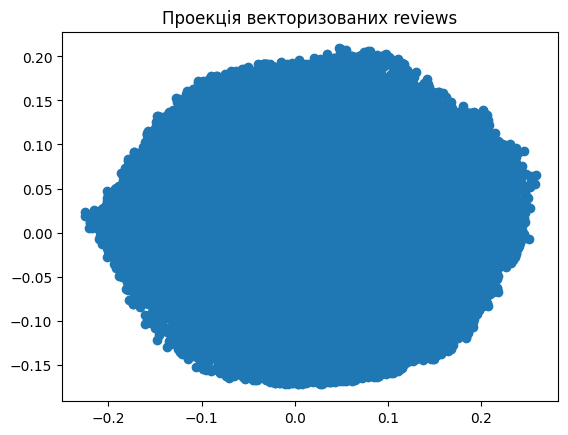

In [19]:
plt.scatter(X_1[:,0], X_1[:,1])
plt.title('Проекція векторизованих reviews')
plt.show()
# Бачимо, що викиди зникли.

## Навчання моделі

### Кластеризація reviews

In [20]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56599 entries, 0 to 59577
Columns: 10000 entries, 00 to zweig
dtypes: float64(10000)
memory usage: 4.2 GB


In [21]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(tfidf_df)
cluster_labels = kmeans.predict(tfidf_df)

# Додаємо мітки кластерів до датасету
df_reviews['Mark'] = kmeans.labels_

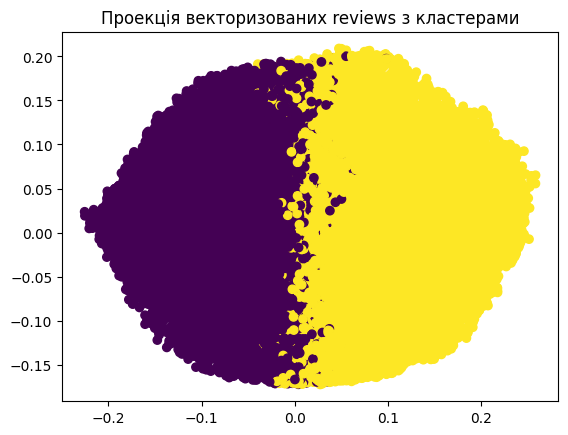

In [22]:
plt.scatter(X_1[:,0], X_1[:,1], c = cluster_labels)
plt.title('Проекція векторизованих reviews з кластерами')
plt.show()

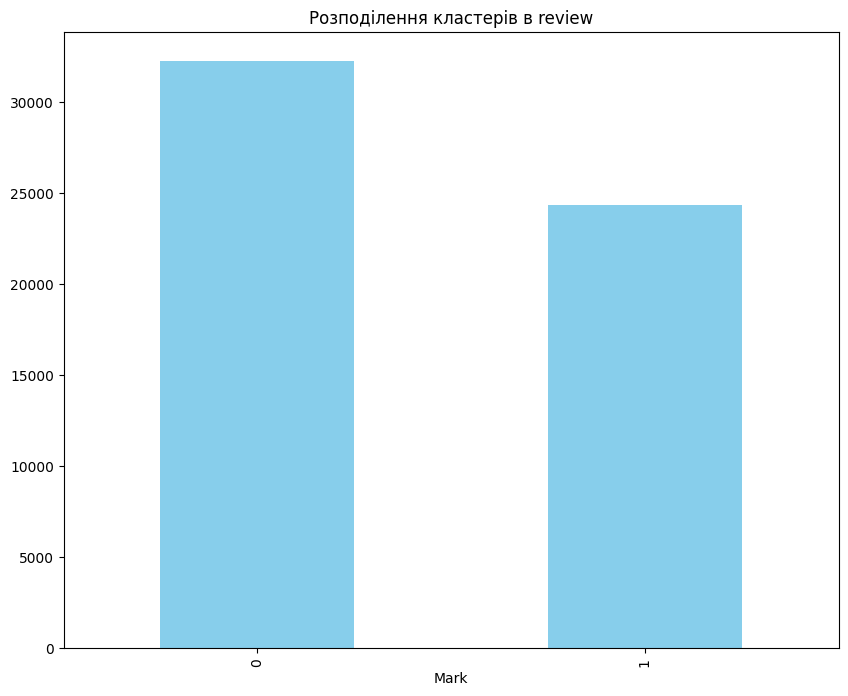

In [23]:
plt.figure(figsize=(10,8))
df_reviews["Mark"].value_counts().plot(kind='bar', color='skyblue')
plt.title('Розподілення кластерів в review')
plt.xticks(rotation=90)
plt.show()

# Рекомендаційна система

## Підготовка df

In [24]:
#Видалення зайвих символів з колонки genres
df_books["genres"] = df_books["genres"].replace(to_replace="[^a-zA-Z\s]", value='', regex=True)

df_books

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kasay\AppData\Local\Temp\ipykernel_2420\371089525.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_books["genres"] = df_books["genres"].replace(to_replace="[^a-zA-Z\s]", value='', regex=True)


,book_id,book_title,book_details,author,genres,average_rating
0,1,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...",J.K. Rowling,Fantasy Young Adult Fiction Magic Childrens Au...,4.58
1,2,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,J.K. Rowling,Young Adult Fiction Magic Childrens Audiobook ...,4.50
2,3,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,J.K. Rowling,Fantasy Fiction Young Adult Magic Childrens Mi...,4.47
3,5,Harry Potter and the Prisoner of Azkaban,"Harry Potter, along with his best friends, Ron...",J.K. Rowling,Fantasy Fiction Young Adult Magic Childrens Mi...,4.58
4,6,Harry Potter and the Goblet of Fire,It is the summer holidays and soon Harry Potte...,J.K. Rowling,Fantasy Young Adult Fiction Magic Childrens Au...,4.57
...,...,...,...,...,...,...
16220,208877606,Finistère,The 1920s. When wealthy American adolescent Ma...,Fritz Peters,Fiction LGBT Queer Classics Gay Gay Fiction Li...,3.77
16221,208877648,The Descent,"Set in the 1950s, The Descent asks the questio...",Fritz Peters,Fiction,4.75
16222,209251042,FDR Unmasked: 73 Years of Medical Cover-ups Th...,THE HIDDEN ILLNESSES THAT SHAPED FDR’S LIFE AN...,Steven Lomazow,Drama Novels Contemporary,4.32
16223,209441121,Code Yellow in Gretna Green,"In Gateway terminology, a ""Code Yellow"" signif...",Linzi Day,Science Fiction Fantasy Fantasy Fiction Epic N...,4.61


In [25]:
#розбиття колонки genres за допомогою get_dummies

# Створення фіктивних змінних для жанрів
genres_dummies = df_books['genres'].str.get_dummies(sep=' ')
genres_dummies = genres_dummies.add_prefix('genre_')

genres_count = genres_dummies.sum().sort_values(ascending=False)
top_25 = genres_count.head(25).index

# Об'єднання з оригінальним DataFrame
df_books = pd.concat([df_books, genres_dummies[top_25]], axis=1)


In [26]:
df_books.drop(columns=["genres"], inplace=True)

In [27]:
df_books

,book_id,book_title,book_details,author,average_rating,genre_Fiction,genre_Fantasy,genre_Adult,genre_Romance,genre_Young,...,genre_Adventure,genre_Paranormal,genre_Horror,genre_History,genre_Crime,genre_Childrens,genre_Biography,genre_Humor,genre_Grade,genre_Middle
0,1,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...",J.K. Rowling,4.58,1,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0
1,2,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,J.K. Rowling,4.50,1,0,1,0,1,...,1,0,0,0,0,1,0,0,1,1
2,3,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,J.K. Rowling,4.47,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,1
3,5,Harry Potter and the Prisoner of Azkaban,"Harry Potter, along with his best friends, Ron...",J.K. Rowling,4.58,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,1
4,6,Harry Potter and the Goblet of Fire,It is the summer holidays and soon Harry Potte...,J.K. Rowling,4.57,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16220,208877606,Finistère,The 1920s. When wealthy American adolescent Ma...,Fritz Peters,3.77,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16221,208877648,The Descent,"Set in the 1950s, The Descent asks the questio...",Fritz Peters,4.75,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16222,209251042,FDR Unmasked: 73 Years of Medical Cover-ups Th...,THE HIDDEN ILLNESSES THAT SHAPED FDR’S LIFE AN...,Steven Lomazow,4.32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16223,209441121,Code Yellow in Gretna Green,"In Gateway terminology, a ""Code Yellow"" signif...",Linzi Day,4.61,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Створення df для векторизації

In [28]:
# Використання dummy змінних для жанрів
genre_columns = [col for col in df_books.columns if col.startswith('genre_')]

# Використання тільки найпопулярніших авторів
popular_authors = df_books['author'].value_counts().index[:500]  #Топ-500 авторів
df_books['popular_author'] = df_books['author'].apply(lambda x: x if x in popular_authors else 'Other')
author_dummies = pd.get_dummies(df_books['popular_author'], prefix='author')

# Об'єднання всіх характеристик
book_features = pd.concat([df_books[genre_columns], author_dummies], axis=1)


## Функція рекомендації

In [29]:
# Обчислення косинусної схожості
cosine_sim = cosine_similarity(book_features, book_features)

# Функція для отримання рекомендацій
def get_recommendations(book_id, Mark, user, cosine_sim=cosine_sim):
    idx = df_books[df_books['book_id'] == book_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    if Mark == 1:
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    else:
        sim_scores = sorted(sim_scores, key=lambda x: x[1])
    
    sim_scores = sim_scores[1:11]  # Отримати топ-10 (або анти-топ) книг
    book_indices = [i[0] for i in sim_scores]
    recommendations = df_books.iloc[book_indices]

    # Формування повідомлення з рекомендаціями
    recommendations_list = []
    for _, row in recommendations.iterrows():
        book_info = f'"{row["book_title"]}" від автора "{row["author"]}": {row["book_details"]}'
        recommendations_list.append(book_info)

    recommendations_message = f'{user}, ось ваші рекомендації після вашого відгуку:\n' + "\n".join(recommendations_list)
    
    return recommendations_message

In [30]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56599 entries, 0 to 61324
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   book            56599 non-null  object
 1   book_id         56599 non-null  int32 
 2   reviewer_name   56599 non-null  object
 3   review_content  56599 non-null  object
 4   Mark            56599 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 2.2+ MB


## Тестування на рекомендаціях з датафрейму

In [31]:
# Приклад використання функції
review_example = df_reviews.iloc[13]  # Рандомний відгук з датафрейму
user_name_example = review_example['reviewer_name']
book_id_example = review_example['book_id']
Mark_example = review_example['Mark']
recommendations_example = get_recommendations(book_id_example, Mark_example,user_name_example)
print(recommendations_example)

Yun, ось ваші рекомендації після вашого відгуку:
"The Virtue of Selfishness: A New Concept of Egoism" від автора "Ayn Rand": Ayn Rand here sets forth the moral principles of Objectivism, the philosophy that holds human life--the life proper to a rational being--as the standard of moral values and regards altruism as incompatible with man's nature, with the creative requirements of his survival, and with a free society.
"Memories of My Melancholy Whores" від автора "Gabriel García Márquez": Memories of My Melancholy Whores is Gabriel García Márquez’s first work of fiction in ten years, written at the height of his powers, the Spanish edition of which Ilan Stavans called, “Masterful. Erotic. As hypnotizing as it is disturbing” (Los Angeles Times).On the eve of his ninetieth birthday, our unnamed protagonist–an undistinguished journalist and lifelong bachelor–decides to give himself “the gift of a night of wild love with an adolescent virgin.”The girl, whom an old madam procures for him, 

# Реалізація

## Збереження даних

In [32]:
# Artem
# The Journeys of Socrates
# "The Journeys of Socrates" by Dan Millman is a literary gem that profoundly touched my heart and soul. From the moment I began reading, I was captivated by the rich, immersive storytelling and the deep philosophical undertones that permeate every chapter. Millman's portrayal of Sergei Ivanov's transformation into Socrates is both moving and inspiring, presenting a hero's journey that is as emotional as it is enlightening.

In [33]:
user_name = str(input("Введіть ваш нікнейм/ім'я:"))
book = str(input("Напишіть назву книги, про яку хочете написати відгук:"))
review = str(input("Напишіть свій відгук:"))

## Знаходження оцінки відгуку

### підготовка тексту

In [34]:
cleaned_review = preprocess_text(review)
#cleaned_review = pd.DataFrame({'cleaned_review': [cleaned_review]})
cleaned_review

"`` the journey socrat '' dan millman literari gem profoundli touch heart soul from moment i began read i captiv rich immers storytel deep philosoph underton permeat everi chapter millman 's portray sergei ivanov 's transform socrat move inspir present hero 's journey emot enlighten"

### Векторизація

In [35]:
vectors_review = tfidf_vectorizer.transform([cleaned_review])
tfidf_review = pd.DataFrame(vectors_review.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#Видалення ознак, що не були в навчанні та додавання нульових значень
for feature in set(tfidf_vectorizer.get_feature_names_out()) - set(tfidf_review.columns):
    tfidf_review[feature] = 0

#Сортування в порядку, як і під час навчання
tfidf_review = tfidf_review[tfidf_vectorizer.get_feature_names_out()]

tfidf_review

,00,000,01,02,03,04,05,07,08,09,...,zero,zeu,zip,zodiac,zoe,zoey,zombi,zone,zoo,zweig
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Передбачення моделі

In [36]:
cluster_label = kmeans.predict(tfidf_review)
mark = cluster_label[0]

print(mark)

0


## Знаходження book_id

In [37]:
book_id = df_books[df_books["book_title"] == book].iloc[0,0]
print(book_id)

531391


In [38]:
print(df_books[df_books["book_id"] == 531391])

      book_id                book_title  \
7058   531391  The Journeys of Socrates   

                                           book_details       author  \
7058  The international bestselling author is bck wi...  Dan Millman   

      average_rating  genre_Fiction  genre_Fantasy  genre_Adult  \
7058            4.34              1              1            0   

      genre_Romance  genre_Young  ...  genre_Paranormal  genre_Horror  \
7058              0            0  ...                 0             0   

      genre_History  genre_Crime  genre_Childrens  genre_Biography  \
7058              0            0                0                0   

      genre_Humor  genre_Grade  genre_Middle  popular_author  
7058            0            0             0           Other  

[1 rows x 31 columns]


## Рекомендація для нового відгуку

In [39]:
recommendations = get_recommendations(book_id, mark, user_name)
print(recommendations)

Artem, ось ваші рекомендації після вашого відгуку:
"In a Sunburned Country" від автора "Bill Bryson": It is the driest, flattest, hottest, most infertile and climatically aggressive of all the inhabited continents, and still Australia teems with life - a large portion of it quite deadly. In fact, Australia has more things that can kill you in a very nasty way than anywhere else.Ignoring such dangers - and yet curiously obsessed by them - Bill Bryson journeyed to Australia and promptly fell in love with the country. And who can blame him? The people are cheerful, extroverted, quick-witted and unfailingly obliging: their cities are safe and clean and nearly always built on water; the food is excellent; the beer is cold and the sun nearly always shines. Life doesn't get much better than this...
"I'm a Stranger Here Myself: Notes on Returning to America After Twenty Years Away" від автора "Bill Bryson": After living in Britain for two decades, Bill Bryson recently moved back to the United 

## Додавання нового відгуку в датафрейм

In [40]:
new_review = pd.DataFrame([{
    'reviewer_name': user_name,
    'book_id': book_id,
    'review_content': review,
    'Mark': mark
}])
df_reviews = pd.concat([df_reviews, new_review], ignore_index=True)

In [41]:
df_reviews

,book,book_id,reviewer_name,review_content,Mark
0,Daughter of the Deep,57094644,Sofia,Just when you thought he was done writing book...,0
1,Daughter of the Deep,57094644,megs_bookrack,Would you be shocked if I told you this was th...,0
2,Daughter of the Deep,57094644,Mariah,So you're telling me Anaisn'ta Daughter of Pos...,0
3,Daughter of the Deep,57094644,ale (semi hiatus) ‧ ₊˚୨ ♡ ୧ ₊˚,"*inserts vine ""anything for you, beyoncé""*upda...",0
4,Seduce Me at Sunrise,2948832,chan ☆,i was excited about this one since it was so w...,0
...,...,...,...,...,...
56595,The Transhumanism Handbook,44242501,Michel Ch,Proved to me that transhumanism is somewhat ch...,0
56596,Teranesia,156787,Rob,"...All things considered,Teranesiais a novel c...",0
56597,Teranesia,156787,Daniel Kenefick,"I don’t understand why Greg Egan generally, an...",1
56598,Teranesia,156787,Tomislav,This is a really amazing book. 10 year old Pra...,0


In [42]:
# Перевірка, чи відгук додався
print(df_reviews[df_reviews["review_content"] == review])

      book  book_id reviewer_name  \
56599  NaN   531391         Artem   

                                          review_content  Mark  
56599  "The Journeys of Socrates" by Dan Millman is a...     0  


# Висновок

In [43]:
# Було зібрано дані з двох файлів та проведено data engineering.
# Оброблені та векторизовані відгуки навчили модель кластеризації на знаходження двох кластерів.
# Була створена рекомендаційна система на основі оцінки відгуку, що дала модель.
# Також реалізована рекомендаційна система, яка видає рекомендації по новому відгуку, та додає його в датафрейм.
# P.s.: На основі предікту нових відгуків бачимо, що кластеризація не є наглядовим методом і не має явних міток, таких як "позитивний" або "негативний". Вона групує дані на основі схожості векторних представлень відгуків.